1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

В качестве подопытного кролика возьмем несложный датасет с предсказанием возникновения диабета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import shap
shap.initjs()



%matplotlib inline

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с 

In [2]:
df = pd.read_csv('C:/Users/u187s/LEARNING/MLB/7/diabetes_prediction_dataset.csv')

In [3]:
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


как видим, датасет смешанный

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
df.isnull()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False,False


посмотрим на соотношение в целевой переменной (здоровых значительно больше, дисбаланс по целевой переменной более 1/10)

In [7]:
df['diabetes'].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

для финалочки посмотреть на уникальные значения, и можно делать вывод о характере датасета

In [8]:
for col in df:
    print("уникальные значения в столбце", col, ":", df[col].unique())

уникальные значения в столбце gender : ['Female' 'Male' 'Other']
уникальные значения в столбце age : [80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]
уникальные значения в столбце hypertension : [0 1]
уникальные значения в столбце heart_disease : [1 0]
уникальные значения в столбце smoking_history : ['never' 'No Info' 'current' 'former' 'ever' 'not current']
уникальные значения в столбце bmi : [25.19 27.32 23.45 ... 59.42 44.39 60.52

В общем и целом уже понятно, что датасет:
- смешанный
- чистый, без пропусков, nan и т.п. мусора
- с определенным, местами огромным дисбалансом классов.
Что касается возможных "выбросов"- не думаю, что в медицинском датасете они вызваны ошибками или ими можно пренебречь: лучше залечить здорового.

что касается алгоритма ML, который стоит выбрать: Раз уж на одном из занятий тема зашла про catboost(к тому же с ним проще), то с ним и поиграем.

Дополнительные плюсы:

- Обработка категориальных признаков: CatBoost автоматически обрабатывает категориальные признаки без необходимости предварительного кодирования. Он использует методы кодирования, такие как Target Encoding и One-Hot Encoding, чтобы преобразовать категориальные признаки в числовые значения.
- Автоматическая обработка пропущенных значений: CatBoost может обрабатывать пропущенные значения в данных без необходимости заполнения или удаления этих значений. Он использует специальное значение "NaN" для пропущенных значений и автоматически учитывает их при обучении модели.
- Работа с текстовыми признаками: CatBoost может обрабатывать текстовые признаки, преобразуя их в числовые значения с помощью методов, таких как Bag of Words и Word Embeddings. Это позволяет использовать текстовую информацию в модели.
- Встроенная обработка временных признаков: CatBoost имеет встроенную поддержку временных признаков, что позволяет учитывать временную зависимость данных при обучении модели.
- Высокая производительность: CatBoost обладает высокой скоростью обучения и предсказания, а также эффективно работает с большими объемами данных.
    Кроме того в нем есть встроенные механизмы уравновешивания, и все*все*все

Таким образом, сей чудесный механизм помог бы нам и с более грязным набором данных, но сейчас он будет трудиться в расслабленном режиме

обучим CatBoost:

In [9]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [10]:
# разобьем датасет
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
cat_features = ['gender', 'smoking_history']

In [12]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy', 'F1']
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
         verbose=False,
         plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [28]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[10], feature_names=X_train.columns)

In [24]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[95], feature_names=X_train.columns)

предполагаю, что на 11-го обследуемого bmi, глюкозный след и возраст влияют крайне сильно в сторону возникновения диабета, а на 96го из трейн выборки отрицательно(но положительно в плане незаболевания), к тому же он еще и не курит. так можно получить данные по каждому номеру

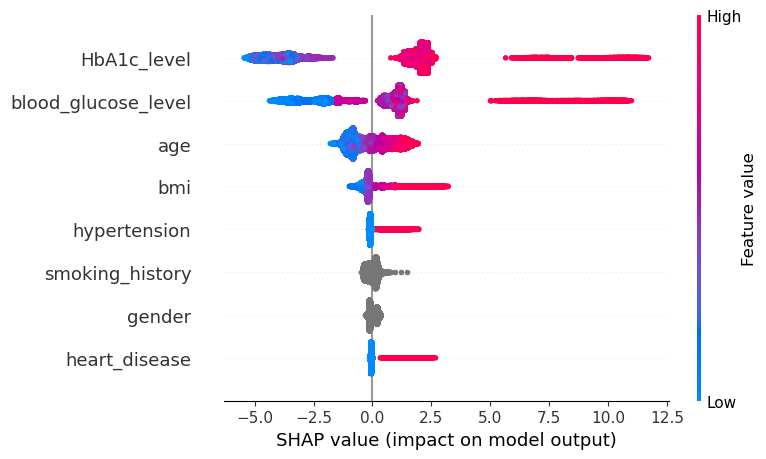

In [16]:
shap.summary_plot(shap_values, X_train)

как наиболее выжные показатели для вероятности возникновения диабета мы видим продолжительность жизни эритроцитов, возраст и в меньшей степени индекс массы тела- основные их значения смещены вправо, и они на графике плотные и красные, что указывает на весомость признака, так же как юный возраст резко снижает вероятность заболевания. естественно с учетом их количества (100к) данные приемлемы для использования